# Spatiotemporal Data

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os

from mne.channels import find_ch_adjacency, make_1020_channel_selections
import mne

from mne_ari.permutation import permutation_test
from mne_ari import all_resolutions_inference

np.random.seed(0)

We'll use the same data as the [MNE tutorial](https://mne.tools/dev/auto_tutorials/stats-sensor-space/20_erp_stats.html) uses for visualizing significance thresholds, so you can check that tutorial out if you want to see a cluster-based permutation test used on this dataset.

In [2]:
# load the data
data_dir = mne.datasets.kiloword.data_path()
fpath = os.path.join(data_dir, 'kword_metadata-epo.fif')
epochs = mne.read_epochs(fpath)
epochs.decimate(4, verbose = 'error')
# divide into conditions based on word length
name = "NumberOfLetters"
median_value = str(epochs.metadata[name].median())
long_words = epochs[name + " > " + median_value]
short_words = epochs[name + " < " + median_value]

Reading /Users/jpveillet/mne_data/MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
Replacing existing metadata with 8 columns
960 matching events found
No baseline correction applied
0 projection items activated


First we compute the adjacency matrix between neighboring sensors so that our clustering routine knows what channels are next to each other.

In [3]:
neighb, _ = find_ch_adjacency(epochs.info, "eeg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 29


Then, we extract the data from our epochs object. (If we were doing this test over subjects instead of over trials, we'd extract from an evoked object.)

In [4]:
X = [short_words.get_data(), long_words.get_data()]
X[0].shape

(384, 29, 64)

Since MNE's clustering routine requires that observations (e.g. trials or subjects) be the first dimension, time be the second dimension, and channels (or whatever the adjacency matrix describes) is the last dimension, we have to flip our array axes.

In [5]:
X = [np.transpose(x, (0, 2, 1)) for x in X]  # transpose for clustering
X[0].shape

(384, 64, 29)

Now, we're ready to run our test. 

You have two options when using `mne_ari`, which you specify in the function call.

1. `ari_type = 'parametric'` selects parametric ARI as described by [Rosenblatt et al. (2018)](https://doi.org/10.1016/j.neuroimage.2018.07.060).
2. `ari_type = 'permutation'` selects permutation-based ARI as described by [Andreella et al. (2020)](https://arxiv.org/abs/2012.00368).

Parametric ARI is the default for this package since the implementation is a bit better tested and is frequently [cross-checked against `nilearn`'s](https://github.com/john-veillette/mne_ari/blob/main/mne_ari/ari/tests/test_hommel.py) to ensure consistent results. Permutation-based ARI, however, affords higher statistical power, since it adapts to the correlation structure between tests. (Note that both of our implementations are technically "permutation based" in the sense that parametric ARI code, by default, uses a permutation test as its mass-univariate test to avoid assumption violations that would impact ARI; it is the multiple comparisons correction that is parametric.)

While [parametric ARI can perform quite well on neuroimaging data](https://doi.org/10.1016/j.neuroimage.2018.07.060), in my experience it's less sensitive than a cluster-based permutation test, since cluster-based tests take better advantage of the spatiotemporal autocorrelation structure of the data. Permutation ARI seems to solve this problem, since it also adapts to the correlation structure of the data, making it well suited to EEG data. That's what we'll use in this example.

In [6]:
alpha = .05
p_vals, tdp, clusters = all_resolutions_inference(X, alpha, tail = 0, # two-sided
                                                  adjacency = neighb, 
                                                  ari_type = 'permutation', 
                                                  n_permutations = 1000
                                                 )

Let's visualize the results of our ARI routine.

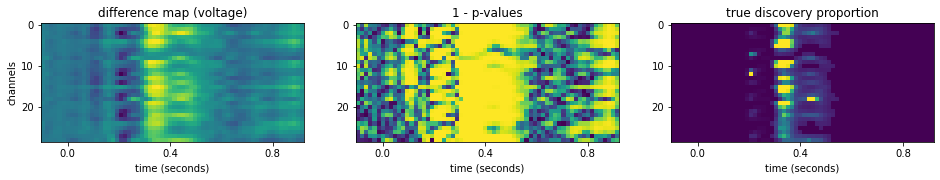

In [7]:
effect_map = X[1].mean(0) - X[0].mean(0)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 8))
axes[0].imshow(effect_map.T)
axes[0].set_title('difference map (voltage)')
axes[0].set_ylabel('channels')
axes[1].imshow(1 - p_vals.T)
axes[1].set_title('1 - p-values')
axes[2].imshow(tdp.T)
axes[2].set_title('true discovery proportion')
ticklabels = [t for t in epochs.times if np.round(t*10) == t*10]
ticks = [i for i in range(effect_map.shape[0]) if epochs.times[i] in ticklabels]
for ax in axes:
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_xlabel('time (seconds)')
plt.show()

You can see that ARI (right) does a good job at suppressing the (presumably) spurious fluctuations you see in the _p_-value grid (middle).

True discovery proportion (TDP) is defined for a subset of all possible tests, so where are all these individual (time, channel) TDP values coming from? The `tdp` array contains the maximum value attained by each (time, channel) pair across all the clustering thresholds searched over. So the plot on the far right is really visualizing the effect of increasing the cluster threshold on the true discovery rate within the clusters. (By default, a evenly log-spaced grid of values between $\alpha$ and $\min(p)$ is searched over, but you can also manually specify a list of values when you call `all_resolutions_inference` with the `threshold` parameter, or you can put `threshold = 'all'` if you want to be really thorough.)

At the end of the day, we only want to keep the clusters for which $\text{TDP} \geq 1 - \alpha$. Let's visualize those.

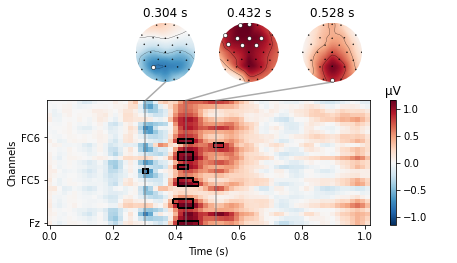

In [8]:
from mne.viz.utils import _prepare_joint_axes, _connection_line

effect = mne.EvokedArray(effect_map.T, epochs.info)
effect.nave = None

# prepare axes
fig, main_ax, map_axs, cbar_ax = _prepare_joint_axes(len(clusters), figsize = None)

# plot effect map
fig = effect.plot_image(
    mask = tdp.T >= 1 - alpha, 
    mask_alpha = 1., # don't fade out
    mask_cmap = 'RdBu_r', # same as unmasked
    show_names = True,
    colorbar = True,
    axes = main_ax,
    show = False
)
main_ax.set_title(' ')
vmin, vmax = main_ax.images[0].get_clim() # remember color limits

# plot topomaps for midpoints of clusters
idx_clusts = [np.median(np.where(clust.sum(1) > 0)) for clust in clusters]
idx_clusts = [int(idx) for idx in idx_clusts]
t_clusts = [effect.times[idx] for idx in idx_clusts]
effect.plot_topomap(times = t_clusts, axes = map_axs, 
                    mask = tdp.T >= 1 - alpha, 
                    mask_params = {'markersize': 8},
                    vmin = vmin,
                    vmax = vmax, # enforce same color limits as main
                    colorbar = False,
                    show = False
                   )

# hide superfluous axes
cbar_ax.grid(False) 
cbar_ax.axis('off')

# draw connecting lines
lines = [_connection_line(timepoint, fig, main_ax, map_ax_)
             for timepoint, map_ax_ in zip(t_clusts, map_axs)]
for line in lines:
    fig.lines.append(line)
for timepoint in t_clusts:
    main_ax.axvline(timepoint, color = 'grey', linestyle = '-',
                      linewidth = 1.5, alpha = .66)
    
    
# show final plot
plt.show()

_The code to generate this figure is laborious enough that I'll probably add some version of it to a new_ `mne_ari.viz` _module for posterity in the near future._

The nice thing about this cluster map is that, in contrast to [cluster-based permutation testing approaches](https://doi.org/10.1016/j.jneumeth.2007.03.024), in which the inclusion of a (time, channel) pair in a cluster [doesn't mean that pair is "significant"](https://doi.org/10.1111/psyp.13335), our ARI-derived clusters allow us to make inferences at the (time, channel) level! Since the TDP is higher than $1 - \alpha$ in each cluster, then under the assumptions of our statistical test, we can reject the null hypothesis for the individual points. Thus, statements like "there is a significant effect 304 ms after stimulus onset" make sense under ARI, while a cluster-based permutation test allows you to make no such statements.

It should be noted that ARI can actually "drill down" to individual (time, channel) pairs if the effect size there is sufficiently large. You might be inclined to ignore singleton clusters if you suspect they're coming from a noise source, but from a purely statistical perspective, these singleton-level inferences are still, in fact, valid.

# Time-Series Data

Let's try ARI on just one channel, to show how you'd use it on a single time series. (This is just for illustration; I wouldn't pick single channels out of your data unless you have an a priori reason to do so.)

In [9]:
X = [short_words.get_data('Cz'), long_words.get_data('Cz')]
X = [np.squeeze(x) for x in X] # get rid of singular dimension
X[0].shape # observations x times

(384, 64)

Since there isn't spatial structure anymore, we don't need to define an adjacency matrix for clustering.

In [10]:
p_vals, tdp, clusters = all_resolutions_inference(X, alpha, ari_type = 'permutation')

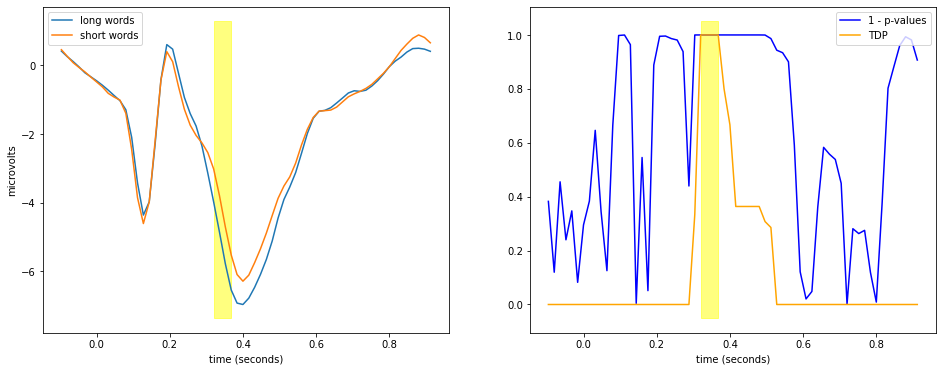

In [11]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
axes[0].plot(epochs.times, X[0].mean(0) * 1e6)
axes[0].plot(epochs.times, X[1].mean(0) * 1e6)
axes[0].legend(['long words', 'short words'])
axes[0].set_ylabel('microvolts')
axes[1].plot(epochs.times, 1 - p_vals, color = 'blue')
axes[1].plot(epochs.times, tdp, color = 'orange')
axes[1].legend(['1 - p-values', 'TDP'], loc = 'upper right')
for ax in axes:
    ax.set_xlabel('time (seconds)')
    for clust in clusters:
        ax.fill_between(epochs.times, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = tdp >= 1 - alpha, color = 'yellow', alpha = 0.5)
plt.show()

# Spatial Data

In [12]:
t_idx = np.min(np.where(epochs.times > .3)) # ~300 ms
X = [short_words.get_data()[:, :, t_idx], long_words.get_data()[:, :, t_idx]]
X[0].shape # observations x channels

(384, 29)

Since we're working with spatial data, we need an adjacency matrix. We'll use the one we defined in the spatiotemporal example above.

In [13]:
p_vals, tdp, clusters = all_resolutions_inference(
    X, alpha, 
    ari_type = 'permutation', 
    adjacency = neighb
)

Now let's plot our spatial cluster on a topomap.

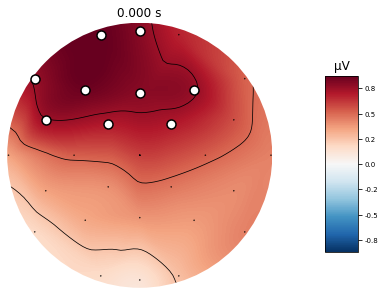

In [14]:
effect = X[1].mean(0) - X[0].mean(0)
effect_map = mne.EvokedArray(effect[:, np.newaxis], epochs.info, tmin = 0.)
effect_map.plot_topomap(
    times = [0], 
    size = 3, 
    mask = tdp[:, np.newaxis] >= 1 - alpha,
    mask_params = {'markersize': 6}
)
plt.show()